<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/Part_2_02_custom_metric_layers_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow

In [2]:
# Step 1: Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Step 2: Load and preprocess dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data()
x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
x_test = (x_test - x_test.mean(axis=0)) / x_test.std(axis=0)

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Step 3: Custom Metric (HuberMetric)
class HuberMetric(keras.metrics.Metric):
    def __init__(self, name="huber_metric", threshold=1.0, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.huber = self.add_weight(name="huber", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - 0.5 * self.threshold)
        loss = tf.where(is_small_error, small_error_loss, big_error_loss)
        self.huber.assign_add(tf.reduce_sum(loss))
        self.count.assign_add(tf.cast(tf.size(loss), tf.float32))

    def result(self):
        return self.huber / self.count

    def reset_state(self):
        self.huber.assign(0.0)
        self.count.assign(0.0)

In [5]:
# Step 4: Custom Dense Layer and Gaussian Noise
class MyDense(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel", shape=(input_shape[-1], self.units), initializer="glorot_uniform")
        self.bias = self.add_weight(name="bias", shape=(self.units,), initializer="zeros")

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel) + self.bias

class AddGaussianNoise(layers.Layer):
    def __init__(self, stddev=0.1):
        super().__init__()
        self.stddev = stddev

    def call(self, inputs, training=False):
        if training:
            return inputs + tf.random.normal(tf.shape(inputs), stddev=self.stddev)
        return inputs

In [6]:
# Step 5: Residual Block with Shape Projection
class ResidualBlock(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense1 = MyDense(units)
        self.norm1 = layers.LayerNormalization()
        self.act1 = layers.Activation("relu")
        self.dense2 = MyDense(units)
        self.projection = None  # created in build()

    def build(self, input_shape):
        input_units = input_shape[-1]
        if input_units != self.dense1.units:
            self.projection = MyDense(self.dense1.units)

    def call(self, inputs):
        shortcut = self.projection(inputs) if self.projection else inputs
        x = self.dense1(inputs)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.dense2(x)
        return self.act1(x + shortcut)

In [7]:
# Step 6: Custom Residual Regressor Model
class ResidualRegressor(keras.Model):
    def __init__(self):
        super().__init__()
        self.noise = AddGaussianNoise(0.1)
        self.block1 = ResidualBlock(64)
        self.block2 = ResidualBlock(64)
        self.output_layer = MyDense(1)

    def call(self, inputs):
        x = self.noise(inputs)
        x = self.block1(x)
        x = self.block2(x)
        return self.output_layer(x)

In [8]:
# Step 7: Compile and Train
model = ResidualRegressor()
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[HuberMetric()]
)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - huber_metric: 20.6461 - loss: 522.4531 - val_huber_metric: 19.2163 - val_loss: 452.3727
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - huber_metric: 16.0412 - loss: 353.7390 - val_huber_metric: 14.7827 - val_loss: 297.8954
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - huber_metric: 12.4185 - loss: 241.5629 - val_huber_metric: 10.4506 - val_loss: 180.0177
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - huber_metric: 8.3554 - loss: 120.4252 - val_huber_metric: 7.3311 - val_loss: 102.4914
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - huber_metric: 6.1888 - loss: 64.9748 - val_huber_metric: 6.6874 - val_loss: 68.7634
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - huber_metric: 6.4783 - loss: 49.1427 - val_huber_metric: 7.1781 - val_loss: 57.2318
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - huber_metric: 7.3616 - loss: 50.4231 - val_huber_metric: 7.6267 - val_loss: 51.4200
Epoch 8/20
11/11 ━━━━━━━━━━

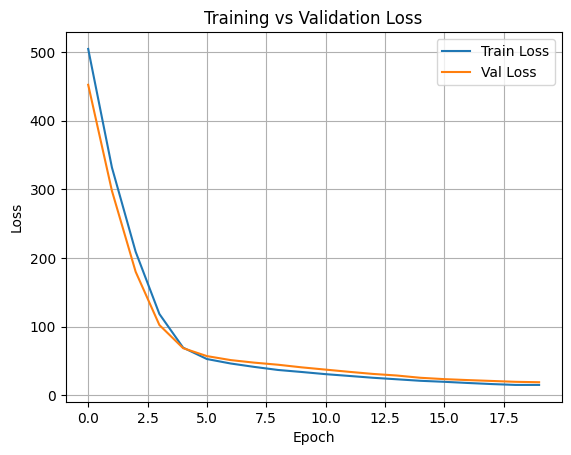

In [9]:
# Step 8: Plot Training vs Validation Loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
